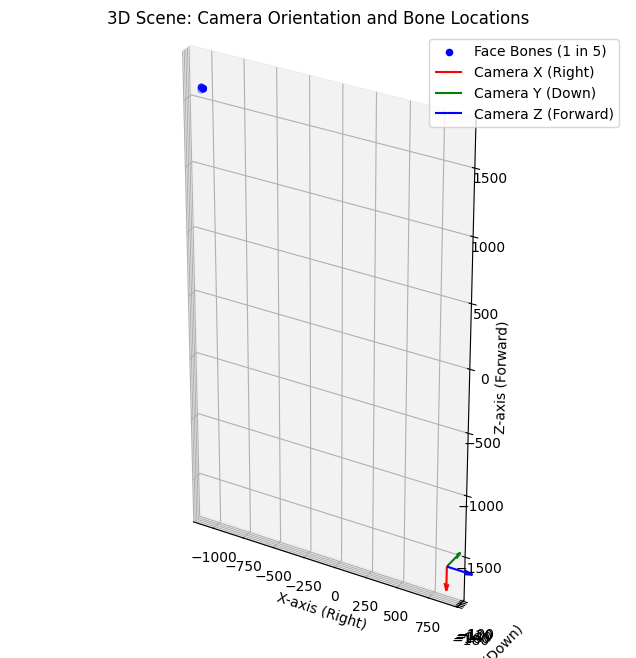

In [1]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Required for 3D plotting

# --- (Helper functions from before are unchanged) ---

def load_extrinsic_matrix(extrinsic_path):
    """Loads just the 4x4 CV extrinsic matrix."""
    with open(extrinsic_path, 'r') as f:
        extrinsic_data = json.load(f)
    return np.array(extrinsic_data['Extrinsics']['ExtrinsicMatrix_CV'])

def load_3d_points_from_unreal(keypoint_file):
    """Loads 3D bone locations from your JSON file."""
    with open(keypoint_file, 'r') as f:
        data = json.load(f)['Keypoints']
    points_3d_ue = []
    for item in data:
        loc = item['WorldLocation']
        points_3d_ue.append([loc['X'], loc['Y'], loc['Z']])
    return np.array(points_3d_ue)

def convert_ue_points_to_cv(points_ue):
    """Converts 3D points from Unreal's coordinate system to the CV standard."""
    points_cv = np.zeros_like(points_ue)
    points_cv[:, 0] =  points_ue[:, 1]
    points_cv[:, 1] = -points_ue[:, 2]
    points_cv[:, 2] =  points_ue[:, 0]
    return points_cv

# --- MAIN WORKFLOW FOR 3D VISUALIZATION ---

if __name__ == "__main__":
    # --- SETUP: Verify your file paths here ---
    saved_path = "C:/Users/20716400/Documents/Unreal Projects/ExtractJointLocation/Saved"
    camera_name = "CineCameraActor_0"
    
    extrinsic_path = os.path.join(saved_path, "CameraData", camera_name, f"Extrinsics_{camera_name}.json")
    keypoints_path = os.path.join(saved_path, "FaceSubset", "BP_Carl_C_1_FaceSubset_BoneLocations.json")

    # --- Step 1: Load the 3D data ---
    extrinsic_matrix_cv = load_extrinsic_matrix(extrinsic_path)
    bone_points_ue = load_3d_points_from_unreal(keypoints_path)
    
    # --- Step 2: Convert and downsample bone points ---
    bone_points_cv = convert_ue_points_to_cv(bone_points_ue)
    
    # --- NEW: Downsample the points to make the plot less cluttered ---
    # This will take every 5th point from the array. You can change the number 5.
    downsample_factor = 5
    sparse_bone_points = bone_points_cv[::downsample_factor]
    
    # --- Step 3: Calculate the camera's 3D position and orientation ---
    R_cv = extrinsic_matrix_cv[0:3, 0:3]
    t_cv = extrinsic_matrix_cv[3, 0:3]
    camera_center_cv = -np.transpose(R_cv) @ t_cv
    
    # Get the camera's axes in the world frame
    cam_x_axis = np.transpose(R_cv)[:, 0]
    cam_y_axis = np.transpose(R_cv)[:, 1]
    cam_z_axis = np.transpose(R_cv)[:, 2]

    # --- Step 4: Create the 3D plot ---
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the SPARSER 3D bone locations
    ax.scatter(sparse_bone_points[:, 0], sparse_bone_points[:, 1], sparse_bone_points[:, 2], 
               c='blue', marker='o', s=20, label=f'Face Bones (1 in {downsample_factor})')
    
    # --- REMOVED: No longer plotting the camera's origin dot ---
    # ax.scatter(camera_center_cv[0], camera_center_cv[1], camera_center_cv[2], c='red', marker='o', s=100, label='Camera Position')
    
    # Plot the camera's orientation axes from its position
    axis_length = 200
    ax.quiver(camera_center_cv[0], camera_center_cv[1], camera_center_cv[2], 
              cam_x_axis[0], cam_x_axis[1], cam_x_axis[2], 
              length=axis_length, color='red', label='Camera X (Right)')
    ax.quiver(camera_center_cv[0], camera_center_cv[1], camera_center_cv[2], 
              cam_y_axis[0], cam_y_axis[1], cam_y_axis[2], 
              length=axis_length, color='green', label='Camera Y (Down)')
    ax.quiver(camera_center_cv[0], camera_center_cv[1], camera_center_cv[2], 
              cam_z_axis[0], cam_z_axis[1], cam_z_axis[2], 
              length=axis_length, color='blue', label='Camera Z (Forward)')

    # --- Formatting the plot for clarity ---
    ax.set_xlabel('X-axis (Right)')
    ax.set_ylabel('Y-axis (Down)')
    ax.set_zlabel('Z-axis (Forward)')
    ax.set_title('3D Scene: Camera Orientation and Bone Locations')
    ax.legend()
    ax.set_aspect('equal', 'box')
    plt.show()